In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.constants import N_A
import math
import seaborn as sns

In [122]:
def selectivity_model(t, z, Atot, r1tot, r2tot, s1tot, s2tot, k1, k2, 
                      q1, q2, p1, t1, koff, qoff, poff, toff):
    
    A00 = Atot - z[0] - z[1] - z[2] - z[3] - z[4]
    r1 = r1tot - z[0] - z[2]
    r2 = r2tot - z[1] - z[2]
    s1 = s1tot - z[3]
    s2 = s2tot - z[4]

    dA10 = k1*A00*r1 - koff*z[0] - q2*z[0]*r2 + qoff*z[2]
    dA01 = q1*A00*r2 - qoff*z[1] - k2*z[1]*r1 + koff*z[2]
    dA11 = q2*z[0]*r2 + k2*z[1]*r1 - (qoff + koff)*z[2]
    dA10_nt = p1*A00*s1 - poff*z[3]
    dA01_nt = t1*A00*s2 -toff*z[4]

    dz = [dA10, dA01, dA11, dA10_nt, dA01_nt]

    return dz

In [123]:
kon = 10**(5)
koff = 10**(-4)
pon = kon
poff = koff

qon = 10**(5)
qoff = 10**(-4)
ton = qon
toff = qoff

Target_cell_number = 2e5
Non_target_cell_number_1 = 2e5
Non_target_cell_number_2 = 2e5
well_size = 125e-6
t_end = 60*60*100
t = np.geomspace(1e-5, t_end, 200)
t_span = [1e-10, t_end]
z0 = np.asarray([0, 0, 0, 0, 0])
tumour_cell_radius = 8e-6
sigma = well_size*N_A

r1tot = 1e5
r1tot = r1tot*Target_cell_number
r2tot = 1e7
r2tot = r2tot*Target_cell_number
s1tot = 1e7
s1tot = s1tot*Non_target_cell_number_1
s2tot = 1e7
s2tot = s2tot*Non_target_cell_number_2

k1 = kon/sigma
p1 = k1
q1 = qon/sigma
t1 = q1

D1 = 1e-14
D2 = 1e-14
k2 = D1/(2*math.pi*(tumour_cell_radius**2)*Target_cell_number)
q2 = D2/(2*math.pi*(tumour_cell_radius**2)*Target_cell_number)

Ainit = 1e-5
Atot = Ainit*sigma
sns.set_theme()

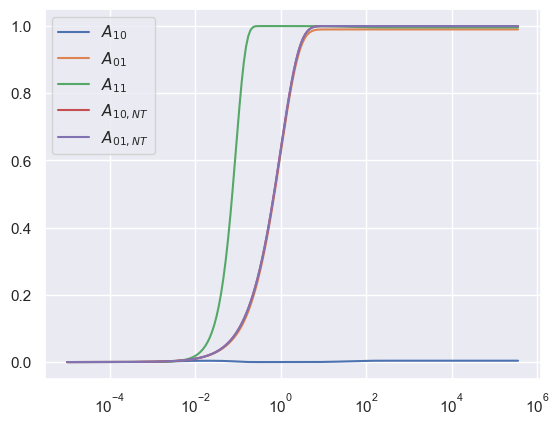

In [124]:
z = solve_ivp(selectivity_model, t_span, z0, method='Radau', t_eval=t, args=(Atot, r1tot, r2tot, s1tot, s2tot, k1, k2, 
                      q1, q2, p1, t1, koff, qoff, poff, toff))

plt.plot(t, z.y[0]/r1tot, label=r'$A_{10}$')
plt.plot(t, z.y[1]/r2tot, label=r'$A_{01}$')
plt.plot(t, z.y[2]/r1tot, label=r'$A_{11}$')
plt.plot(t, z.y[3]/s1tot, label=r'$A_{10, NT}$')
plt.plot(t, z.y[4]/s2tot, label=r'$A_{01, NT}$')

plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [125]:
A0s = np.geomspace(1e-13, 5e-5, 200)

r1tots = [1e3, 1e4, 1e5, 1e6, 1e7]
target_props = []


for r1tot in r1tots:
    #s1tot = r1tot
    r1tot = r1tot*Target_cell_number
    #s1tot = s1tot*Non_target_cell_number_1
    A10_array = np.zeros_like(A0s)
    A01_array = np.zeros_like(A0s)
    A11_array = np.zeros_like(A0s)
    A10_nt_array = np.zeros_like(A0s)
    A01_nt_array = np.zeros_like(A0s)
    for i, Ainit in enumerate(A0s):
        Atot = Ainit*sigma
        z = solve_ivp(selectivity_model, t_span, z0, method='Radau', t_eval=t, args=(Atot, r1tot, r2tot, s1tot, s2tot, k1, k2, 
                      q1, q2, p1, t1, koff, qoff, poff, toff))
    
        A10 = z.y[0]
        A01 = z.y[1]
        A11 = z.y[2]
        A10_nt = z.y[3]
        A01_nt = z.y[4]

        A10_array[i] = A10[-1]
        A01_array[i] = A01[-1]
        A11_array[i] = A11[-1]
        A10_nt_array[i] = A10_nt[-1]
        A01_nt_array[i] = A01_nt[-1]
    
    target_prop = ((A10_array + A11_array + A01_array))/(A10_array + A11_array + A01_array+ A10_nt_array + A01_nt_array)
    target_props.append(target_prop)
  

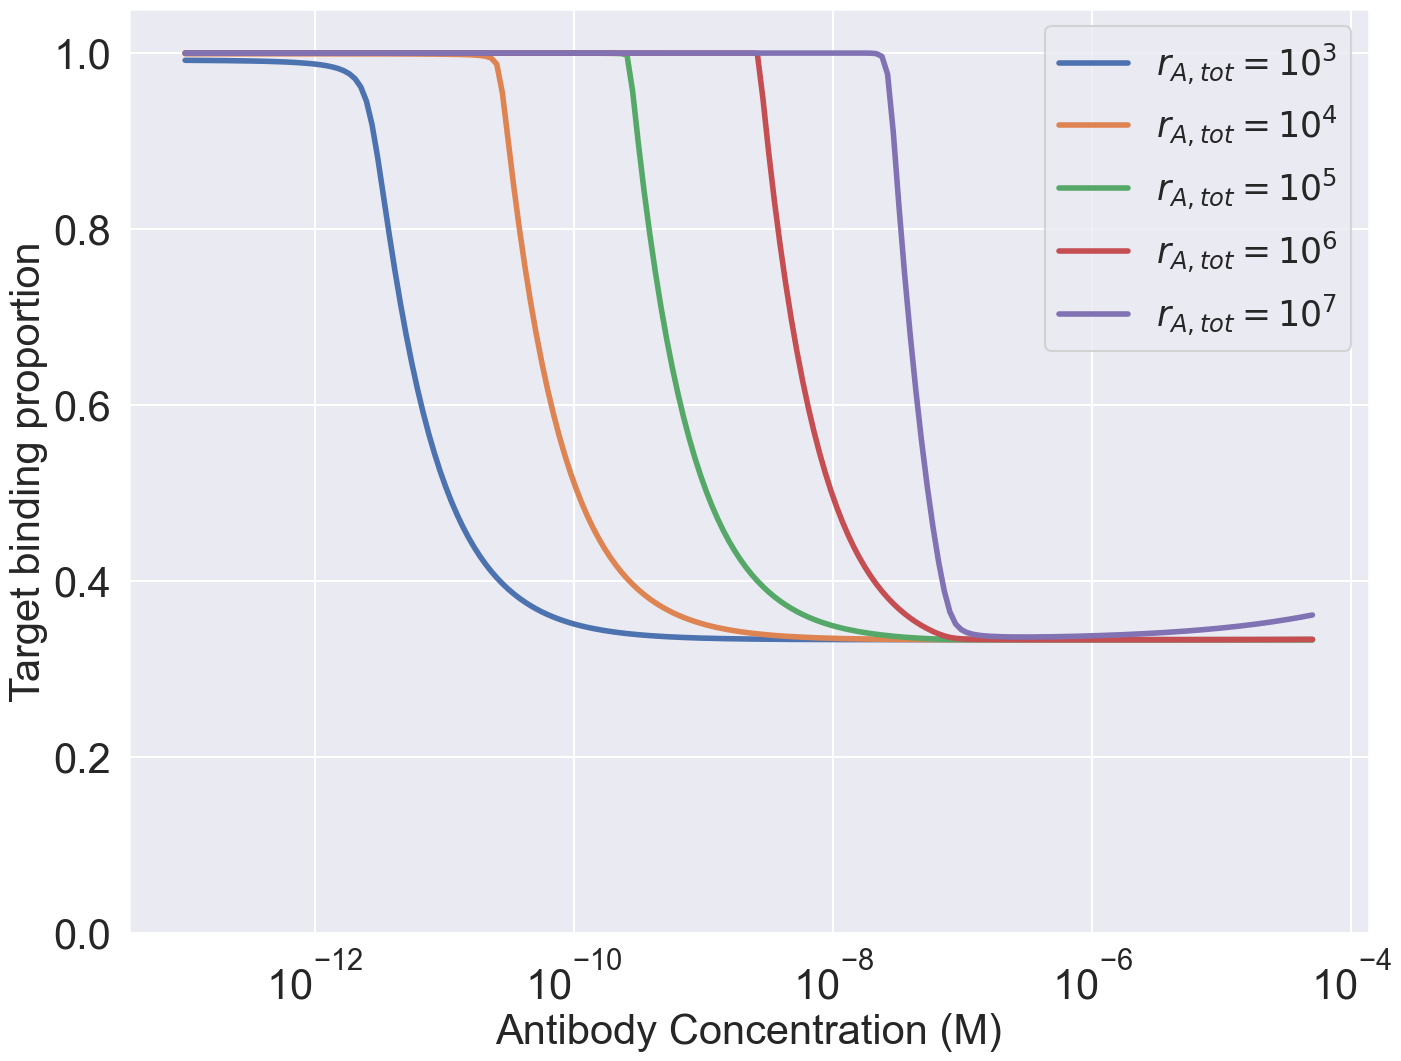

In [126]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(16, 12))
labels=[r'$r_{A, tot}=10^3$', r'$r_{A, tot}=10^4$', r'$r_{A, tot}=10^5$', r'$r_{A, tot}=10^6$', r'$r_{A, tot}=10^7$']
for i in range(len(r1tots)):
    ax.semilogx(A0s, target_props[i], label=labels[i], lw=4)

ax.tick_params(labelsize=30)
plt.legend(loc='best', fontsize=25)
plt.xlabel('Antibody Concentration (M)', fontsize=30)
plt.ylabel('Target binding proportion', fontsize=30)
plt.ylim((0, 1.05))
plt.show()

In [127]:
Ainit = 1e-8
Atot = Ainit*sigma
r1tots = np.geomspace(1e3, 1e6, 100)
r2tots = np.geomspace(1e3, 1e6, 100)
Y = np.zeros((len(r1tots), len(r2tots)))

for i, r1tot in enumerate(r1tots):
    r1tot = r1tot*Target_cell_number
    s1tot = r1tot*(Non_target_cell_number/Target_cell_number)
    for j, r2tot in enumerate(np.flip(r2tots)):
        r2tot = r2tot*Target_cell_number
        z = solve_ivp(selectivity_model, t_span, z0, method='Radau', t_eval=t, args=(Atot, r1tot, r2tot, s1tot, k1, k2, 
                      q1, q2, p1, koff, qoff, poff))
        
        A10 = z.y[0]
        A01 = z.y[1]
        A11 = z.y[2]
        A10_nt = z.y[3]
        A10_st = A10[-1]
        A01_st = A01[-1]
        A11_st = A11[-1]
        A10_nt_st = A10_nt[-1]

        selectivity = ((A10_st + A11_st + A01_st))/(A10_nt_st)
        Y[i, j] = selectivity

NameError: name 'Non_target_cell_number' is not defined